# Economic Analysis with Pandas

In [6]:
!pip install fredapi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import config

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = config.FRED_API_KEY

# 1. Create the Fred Object

In [4]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [7]:
sp_search = fred.search('S&P', order_by='popularity')


In [8]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2025-03-11,2025-03-11,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2025-03-07,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-03-10 09:06:06-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2025-03-11,2025-03-11,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2024-12-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2025-02-25 08:11:20-06:00,88,"For more information regarding the index, plea..."
SP500,SP500,2025-03-11,2025-03-11,S&P 500,2015-03-11,2025-03-10,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2025-03-10 19:11:20-05:00,83,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2025-03-11,2025-03-11,ICE BofA US High Yield Index Effective Yield,1996-12-31,2025-03-07,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-03-10 09:06:09-05:00,82,This data represents the effective yield of th...
BAMLC0A0CM,BAMLC0A0CM,2025-03-11,2025-03-11,ICE BofA US Corporate Index Option-Adjusted Sp...,1996-12-31,2025-03-07,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-03-10 09:14:01-05:00,78,The ICE BofA Option-Adjusted Spreads (OASs) ar...


# 3. Pull Raw Data & Plot

In [10]:
sp500 = fred.get_series(series_id='SP500')

<Axes: title={'center': 'S&P 500'}>

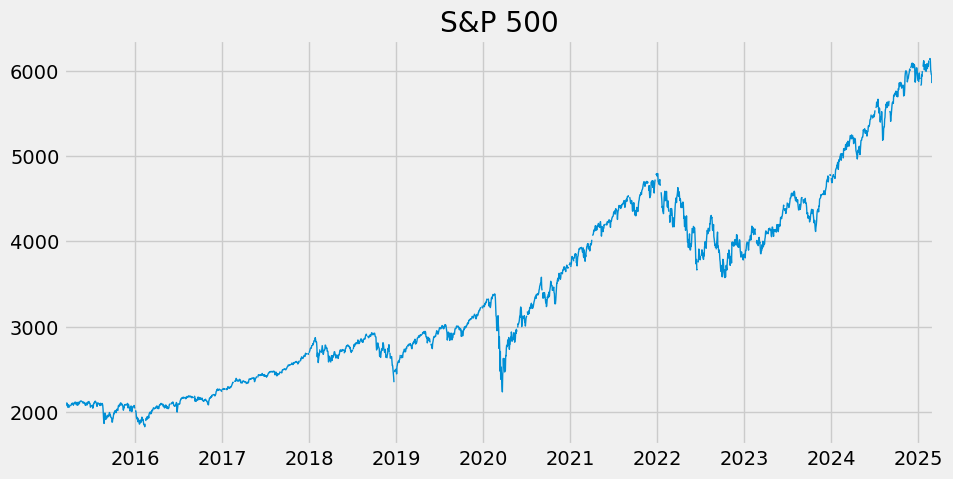

In [14]:
sp500.plot(figsize=(10,5), title='S&P 500', lw=1)

# 4. Pull and Join Multiple Data Series

In [48]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [ ]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
    

In [ ]:
all_results[1]